# Importing Libraries and dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.tree import plot_tree

In [2]:
# Importing dataset
cardio_df:pd.DataFrame = pd.read_csv("dataset.csv")

In [3]:
# Overview of dataset
cardio_df.head()

Gender  Age  Height(cm)  Weight(kg) Family_history Alcohol Junk_food  \
0  Female   42       172.2        82.9             no     low       yes   
1  Female   19       175.3        80.0            yes    none       yes   
2  Female   43       158.3        81.9            yes    none       yes   
3  Female   23       165.0        70.0            yes     low        no   
4    Male   23       169.0        75.0            yes     low       yes   

   Vege_day  Meals_day      Snack Smoking  Water_intake(L) Transportation  \
0         3          3  Sometimes      no             2.72            car   
1         2          1  Sometimes      no             2.65            bus   
2         3          1  Sometimes      no             1.89            car   
3         2          1  Sometimes      no             2.00            bus   
4         3          3  Sometimes      no             2.82            bus   

   Exercise        TV  Income Discipline Cardiovascular_risk(y)  
0         3      rare    2081         no                 medium  
1         3  moderate    5551         no                 medium  
2         1      rare   14046         no                   high  
3         0      rare    9451         no                 medium  
4         1     often   17857         no                 medium

# Preprocessing

In [4]:
# Encode features
def encode_features(dataframe: pd.DataFrame)->pd.DataFrame:
    # LabelBinarizer encoding
    label_binarizer = LabelBinarizer()
    dataframe['Gender'] = label_binarizer.fit_transform(dataframe['Gender'])
    dataframe['Family_history'] = label_binarizer.fit_transform(dataframe['Family_history'])
    dataframe['Junk_food'] = label_binarizer.fit_transform(dataframe['Junk_food'])
    dataframe['Smoking'] = label_binarizer.fit_transform(dataframe['Smoking'])
    dataframe['Discipline'] = label_binarizer.fit_transform(dataframe['Discipline'])

    # OrdinalEncoder encoding
    ordinal_encoder = OrdinalEncoder(categories=[['none', 'low', 'medium', 'high']])
    dataframe['Alcohol'] = ordinal_encoder.fit_transform(dataframe[['Alcohol']])

    ordinal_encoder = OrdinalEncoder(categories=[['rare', 'moderate', 'often']])
    dataframe['TV'] = ordinal_encoder.fit_transform(dataframe[['TV']])

    ordinal_encoder = OrdinalEncoder(categories=[['No', 'Sometimes', 'Frequently', 'Always']])
    dataframe['Snack'] = ordinal_encoder.fit_transform(dataframe[['Snack']])

    ordinal_encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])
    dataframe['Cardiovascular_risk(y)'] = ordinal_encoder.fit_transform(dataframe[['Cardiovascular_risk(y)']])

    # OneHotEncoder for 'Transportation'
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    transportation_encoded_df = pd.DataFrame(one_hot_encoder.fit_transform(dataframe[['Transportation']]), columns=one_hot_encoder.get_feature_names_out(['Transportation']))
    
    dataframe = pd.concat([dataframe, transportation_encoded_df], axis=1)
    return dataframe

# Add new features
def add_features(dataframe:pd.DataFrame)->pd.DataFrame:
    dataframe['BMI'] = (dataframe['Weight(kg)']/np.square(dataframe['Height(cm)']/10)).apply(lambda x:round(x,2))
    dataframe['Age_category'] = pd.cut(dataframe['Age'], bins=[13, 20, 30, 40, dataframe['Age'].max()], labels=[1, 2, 3, 4])
    return dataframe

# Drop unnecessary features
def drop_features(dataframe:pd.DataFrame)->pd.DataFrame:
    dataframe.drop(columns=['Age', 'Weight(kg)', 'Height(cm)', 'Transportation'], inplace=True)
    return dataframe

# Define a function to remove outliers using the IQR method
def remove_outliers_iqr(dataframe, columns):
    for column in columns:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1-1.5*IQR
        upper_bound = Q3+1.5*IQR
        dataframe = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
    return dataframe

In [5]:
# Perform preprocessing
cardio_df = add_features(cardio_df)
cardio_df = encode_features(cardio_df)
cardio_df = remove_outliers_iqr(cardio_df, ['Age', 'BMI', 'Exercise'])
cardio_df = drop_features(cardio_df)

In [6]:
# Checking dataframe size after processing
print(cardio_df.shape)

(1942, 21)


In [7]:
# Checking dataframe value
cardio_df

Gender  Family_history  Alcohol  Junk_food  Vege_day  Meals_day  Snack  \
1          0               1      0.0          1         2          1    1.0   
3          0               1      1.0          0         2          1    1.0   
4          1               1      1.0          1         3          3    1.0   
5          1               1      1.0          1         2          1    1.0   
6          0               1      1.0          1         3          3    1.0   
...      ...             ...      ...        ...       ...        ...    ...   
2094       1               1      1.0          1         2          3    1.0   
2095       1               1      1.0          1         3          3    1.0   
2096       1               1      1.0          1         1          1    1.0   
2097       1               1      2.0          1         2          3    2.0   
2098       1               1      0.0          1         2          3    1.0   

      Smoking  Water_intake(L)  Exercise  ...  Income  Discipline  \
1           0             2.65         3  ...    5551           0   
3           0             2.00         0  ...    9451           0   
4           0             2.82         1  ...   17857           0   
5           0             1.00         1  ...    3114           0   
6           0             2.42         2  ...    8011           0   
...       ...              ...       ...  ...     ...         ...   
2094        0             2.29         1  ...    4717           0   
2095        0             2.74         1  ...    6708           0   
2096        0             2.00         1  ...   13716           0   
2097        0             3.00         1  ...    4347           0   
2098        0             2.00         0  ...    1376           0   

      Cardiovascular_risk(y)   BMI  Age_category Transportation_bicycle  \
1                        1.0  0.26             1                    0.0   
3                        1.0  0.26             2                    0.0   
4                        1.0  0.26             2                    0.0   
5                        1.0  0.28             2                    0.0   
6                        2.0  0.45             2                    0.0   
...                      ...   ...           ...                    ...   
2094                     1.0  0.26             1                    0.0   
2095                     1.0  0.28             1                    0.0   
2096                     0.0  0.22             1                    0.0   
2097                     1.0  0.26             1                    0.0   
2098                     2.0  0.33             2                    0.0   

      Transportation_bus  Transportation_car  Transportation_motorcycle  \
1                    1.0                 0.0                        0.0   
3                    1.0                 0.0                        0.0   
4                    1.0                 0.0                        0.0   
5                    1.0                 0.0                        0.0   
6                    1.0                 0.0                        0.0   
...                  ...                 ...                        ...   
2094                 1.0                 0.0                        0.0   
2095                 1.0                 0.0                        0.0   
2096                 1.0                 0.0                        0.0   
2097                 1.0                 0.0                        0.0   
2098                 1.0                 0.0                        0.0   

      Transportation_walk  
1                     0.0  
3                     0.0  
4                     0.0  
5                     0.0  
6                     0.0  
...                   ...  
2094                  0.0  
2095                  0.0  
2096                  0.0  
2097                  0.0  
2098                  0.0  

[1942 rows x 21 columns]

In [8]:
# Splitting the features and label from the original dataset
X_cardio_df:pd.DataFrame = cardio_df.drop(columns='Cardiovascular_risk(y)')
y_cardio_df:pd.Series= cardio_df['Cardiovascular_risk(y)']

# Extracting the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_cardio_df, y_cardio_df, test_size=0.2, random_state=42, stratify=y_cardio_df)

In [9]:
# Checking data size
print('cardio_df: ', cardio_df.shape)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

cardio_df:  (1942, 21)
X_train:  (1553, 20)
X_test:  (389, 20)
y_train:  (1553,)
y_test:  (389,)


# Model Training

## K-Fold Cross Validation

In [10]:
# Initialize the Random Forest classifier
fold_rf_model:RandomForestClassifier = RandomForestClassifier(random_state=42)

# Getting the folds 
skf:StratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variable
cv_accuracy_score:list[float] = []
cv_precision_score:list[float] = []
cv_recall_score:list[float] = []
cv_f1_score:list[float] = []

# Perform Stratified K-Fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    # selecting the random feature set and label set
    fold_X_train, fold_X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    fold_y_train, fold_y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the current fold
    fold_rf_model.fit(fold_X_train, fold_y_train)

    # Predict on the validation fold
    fold_y_pred:np.array = fold_rf_model.predict(fold_X_train)

    # Calculate evaluation metrics for this fold
    accuracy:float = accuracy_score(fold_y_train, fold_y_pred)
    precision:float = precision_score(fold_y_train, fold_y_pred, average='weighted')
    recall:float = recall_score(fold_y_train, fold_y_pred, average='weighted')
    f1:float = f1_score(fold_y_train, fold_y_pred,average='weighted')

    # Store the scores
    cv_accuracy_score.append(accuracy)
    cv_precision_score.append(precision)
    cv_recall_score.append(recall)
    cv_f1_score.append(f1)

# Print the cross-validation scores and averages
print(f'Cross-Validation Accuracy Scores:\n{cv_accuracy_score}')
print(f'Average Accuracy: {sum(cv_accuracy_score) / len(cv_accuracy_score)}\n')

print(f'Cross-Validation Precision Scores:\n{list(map(float, cv_precision_score))}')
print(f'Average Precision: {sum(cv_precision_score) / len(cv_precision_score)}\n')

print(f'Cross-Validation Recall Scores:\n{list(map(float, cv_recall_score))}')
print(f'Average Recall: {sum(cv_recall_score) / len(cv_recall_score)}\n')

print(f'Cross-Validation F1 Scores:\n{list(map(float, cv_f1_score))}')
print(f'Average F1: {sum(cv_f1_score) / len(cv_f1_score)}')

Cross-Validation Accuracy Scores:
[1.0, 1.0, 1.0, 1.0, 1.0]
Average Accuracy: 1.0

Cross-Validation Precision Scores:
[1.0, 1.0, 1.0, 1.0, 1.0]
Average Precision: 1.0

Cross-Validation Recall Scores:
[1.0, 1.0, 1.0, 1.0, 1.0]
Average Recall: 1.0

Cross-Validation F1 Scores:
[1.0, 1.0, 1.0, 1.0, 1.0]
Average F1: 1.0


## Evaluation of Training Model

In [11]:
# Initialize the Random Forest classifier
rf_model:RandomForestClassifier = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Predict on the training set
y_train_pred:np.array = rf_model.predict(X_train)
   
# Calculate evaluation metrics on the training set
train_accuracy:float = accuracy_score(y_train, y_train_pred)
train_precision:float = precision_score(y_train, y_train_pred, average='weighted')
train_recall:float = recall_score(y_train, y_train_pred,  average='weighted')
train_f1:float = f1_score(y_train, y_train_pred, average='weighted')

# Print the evaluation metrics for the training model
print("Training Model:")
print(f'Accuracy: {train_accuracy}')
print(f'Precision: {train_precision}')
print(f'Recall: {train_recall}')
print(f'F1: {train_f1}')

Training Model:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


### Classification Report

In [13]:
# Classification report for the training set
report:classification_report = classification_report(y_train, y_train_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00       439
      medium       1.00      1.00      1.00       417
        high       1.00      1.00      1.00       697

    accuracy                           1.00      1553
   macro avg       1.00      1.00      1.00      1553
weighted avg       1.00      1.00      1.00      1553



### Confusion Matrix

<Figure size 1200x800 with 0 Axes>

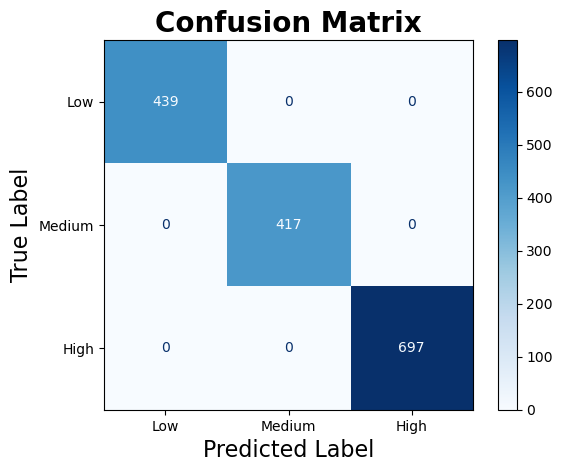

In [14]:
# Compute confusion matrix
cm:confusion_matrix = confusion_matrix(y_train, y_train_pred, labels=[0, 1, 2])
plt.figure(figsize=(12, 8))

# Display confusion matrix
disp:ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap=plt.cm.Blues)

# Display setting
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()

### ROC-AUC Curve

AUC = 0.9992
AUC = 0.9988
AUC = 1.0000


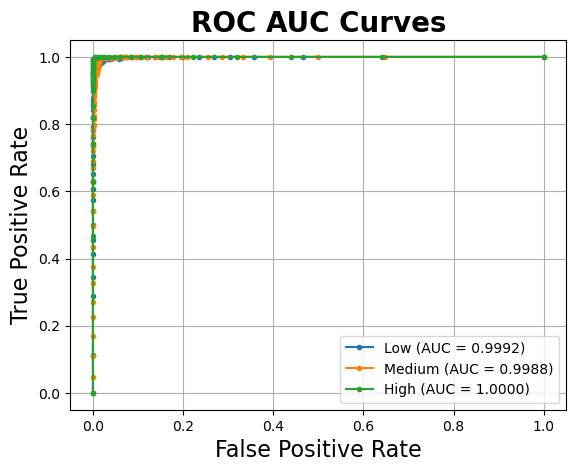

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = cross_val_predict(rf_model, X_train, y_train, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_train == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_train == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))
    
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC AUC Curves', fontsize=20, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Training Learning Curves

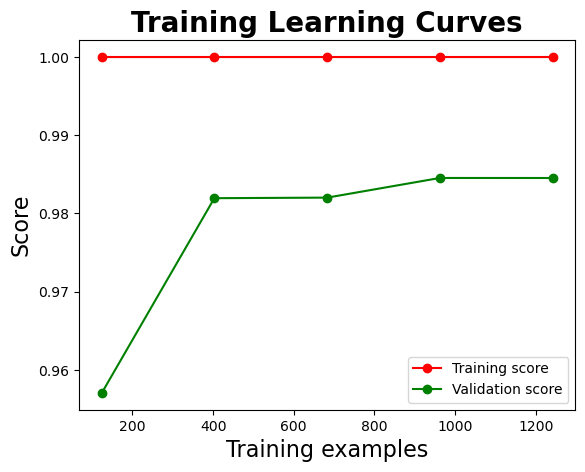

In [17]:
# Generate learning curves using the RandomForest model with 5-fold cross-validation
train_sizes, train_scores, val_scores = learning_curve(rf_model, X_train, y_train, cv=5, scoring='f1_weighted')

# Calculate the mean and standard deviation of training and validation scores across the folds
train_scores_mean:np.ndarray = train_scores.mean(axis=1)
train_scores_std:np.ndarray = train_scores.std(axis=1)
val_scores_mean:np.ndarray = val_scores.mean(axis=1)
val_scores_std:np.ndarray = val_scores.std(axis=1)

# Display training learning curves
plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.xlabel('Training examples', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.title('Training Learning Curves', fontsize=20, fontweight='bold' )
plt.legend(loc='lower right')
plt.show()

# Testing Model

## Evaluation of Testing Model

In [18]:
# Predict on the Testing set
y_test_pred:np.array = rf_model.predict(X_test)

# Calculate evaluation metrics on the Testing set
test_accuracy:float = accuracy_score(y_test, y_test_pred)
test_precision:float = precision_score(y_test, y_test_pred, average='weighted')
test_recall:float = recall_score(y_test, y_test_pred,  average='weighted')
test_f1_score:float = f1_score(y_test, y_test_pred, average='weighted')

# Print the evaluation metrics for the Testing model
print(f'Testing Model:')
print(f'Accuracy: {test_accuracy}')
print(f'Precision: {test_precision}')
print(f'Recall: {test_recall}')
print(f'F1: {test_f1_score}')

Testing Model:
Accuracy: 0.9897172236503856
Precision: 0.9897082455173656
Recall: 0.9897172236503856
F1: 0.9897032781140256


### Classification Report

In [19]:
# Classification report for the test set
report:classification_report = classification_report(y_test, y_test_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       0.99      0.98      0.99       110
      medium       0.98      0.98      0.98       104
        high       0.99      1.00      1.00       175

    accuracy                           0.99       389
   macro avg       0.99      0.99      0.99       389
weighted avg       0.99      0.99      0.99       389



### Confusion Matrix

<Figure size 1200x800 with 0 Axes>

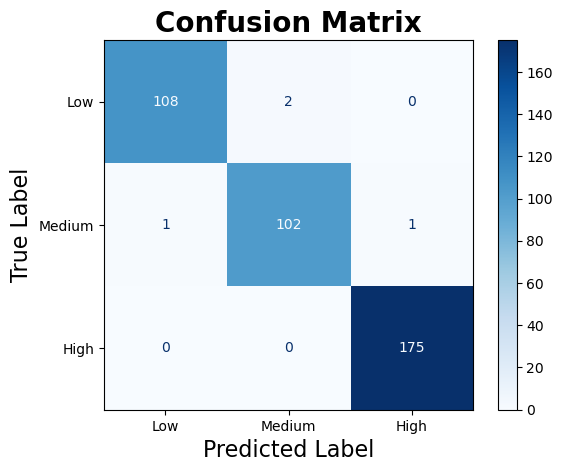

In [20]:
# Compute confusion matrix
cm:confusion_matrix = confusion_matrix(y_test, y_test_pred, labels=[0, 1, 2])
plt.figure(figsize=(12, 8))

# Display confusion matrix
disp:ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap=plt.cm.Blues)

# Display setting
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()

### ROC-AUC Curve

AUC = 0.9992
AUC = 0.9988
AUC = 1.0000


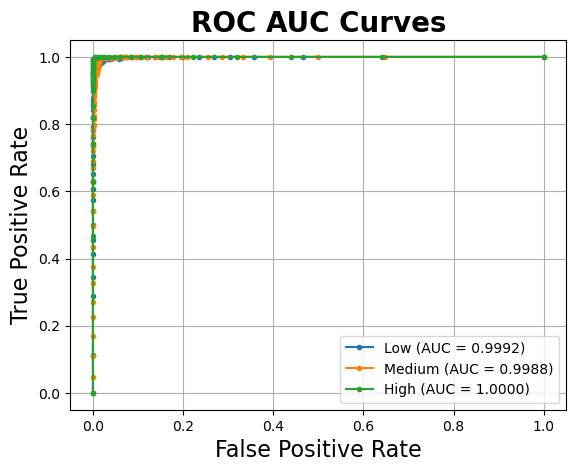

In [22]:
# For Decision Trees, you typically use predict_proba for probabilities
y_pred_proba = cross_val_predict(rf_model, X_train, y_train, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

# Compute ROC curve and ROC AUC score
for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_train == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_train == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))
    
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC AUC Curves', fontsize=20, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Fine Tuning

In [24]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],  # Smaller number of trees to avoid overfitting
    'max_features': ['sqrt', 'log2'],  # Common values for Random Forest
    'max_depth': [None, 10, 20, 30],  # Depths that allow for enough splits but prevent overfitting
    'min_samples_leaf': [1, 2, 4],  # To control the minimum number of samples per leaf
    'min_samples_split': [2, 5, 10],  # Standard values to balance the number of splits
}

# Create a Random Forest model
tuned_rf_model:RandomForestClassifier = RandomForestClassifier(random_state=42)

# Set up Grid Search
grid_search:GridSearchCV = GridSearchCV(estimator=tuned_rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Print the best parameters and timing information
print("Best parameters: ", grid_search.best_params_)
print("Best Accuracy Score: {:.4f}".format(grid_search.best_score_))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Accuracy Score: 0.9858


In [25]:
# Show important features
feature_importances = grid_search.best_estimator_.feature_importances_
feature_names = X_train.columns.tolist()
sorted(zip(feature_importances, feature_names), reverse=True)

[(0.628371824774144, 'BMI'),
 (0.06899381196701886, 'Family_history'),
 (0.0659309365504492, 'Snack'),
 (0.04030197283309448, 'Water_intake(L)'),
 (0.03705172279972362, 'Age_category'),
 (0.025579448945938964, 'Meals_day'),
 (0.019448791401356257, 'Income'),
 (0.01818504352764438, 'Vege_day'),
 (0.01749940012365146, 'Junk_food'),
 (0.014949325095762496, 'Alcohol'),
 (0.013127840863620482, 'Exercise'),
 (0.010388342956559595, 'TV'),
 (0.01019546066856738, 'Gender'),
 (0.008638819431954162, 'Transportation_bus'),
 (0.007966864078749237, 'Discipline'),
 (0.0067984830492083944, 'Transportation_car'),
 (0.0036203202630557007, 'Transportation_walk'),
 (0.0024609669002101224, 'Smoking'),
 (0.0003221373948257011, 'Transportation_motorcycle'),
 (0.00016848637446540972, 'Transportation_bicycle')]

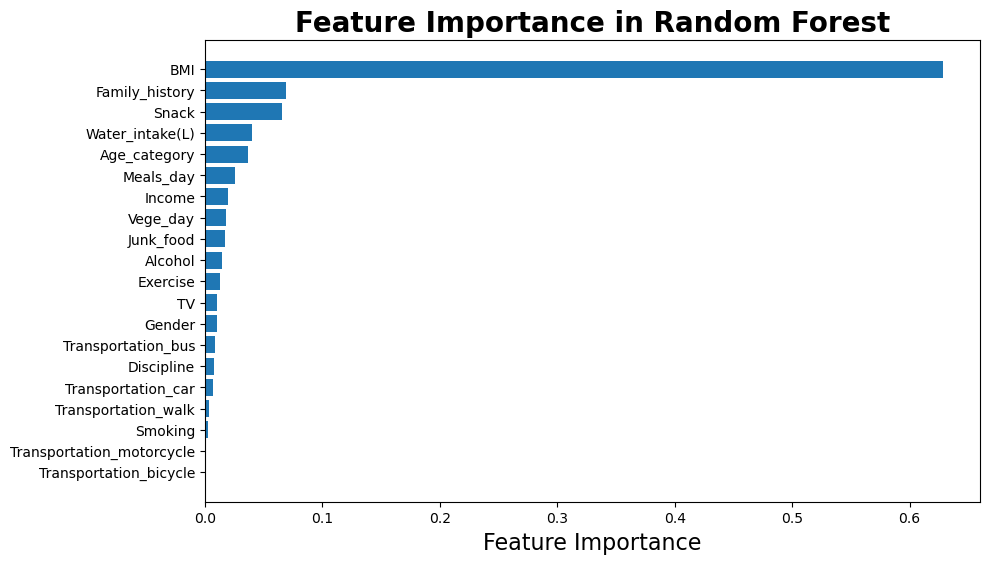

In [26]:
# Display setting
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance", fontsize=16)
plt.title("Feature Importance in Random Forest", fontsize=20, fontweight='bold')
plt.show()

In [27]:
# Use the best estimator
best_rf_model = grid_search.best_estimator_
y_tuned_pred:np.array = best_rf_model.predict(X_test)

# Calculate evaluation metrics on the training set
tuned_accuracy:float = accuracy_score(y_test, y_tuned_pred)
tuned_precision:float = precision_score(y_test, y_tuned_pred, average='weighted')
tuned_recall:float = recall_score(y_test, y_tuned_pred,  average='weighted')
tuned_f1:float = f1_score(y_test, y_tuned_pred, average='weighted')

# Print the evaluation metrics for the training model
print("Tuned Metrics:")
print(f'Accuracy: {tuned_accuracy}')
print(f'Precision: {tuned_precision}')
print(f'Recall: {tuned_recall}')
print(f'F1: {tuned_f1}')

Tuned Metrics:
Accuracy: 0.9922879177377892
Precision: 0.9923132989900282
Recall: 0.9922879177377892
F1: 0.992288760201605


### Classification Report

In [28]:
# Classification report for the test set
report:classification_report = classification_report(y_test, y_tuned_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       0.99      0.98      0.99       110
      medium       0.98      0.99      0.99       104
        high       1.00      1.00      1.00       175

    accuracy                           0.99       389
   macro avg       0.99      0.99      0.99       389
weighted avg       0.99      0.99      0.99       389



### Confusion Matrix

<Figure size 1200x800 with 0 Axes>

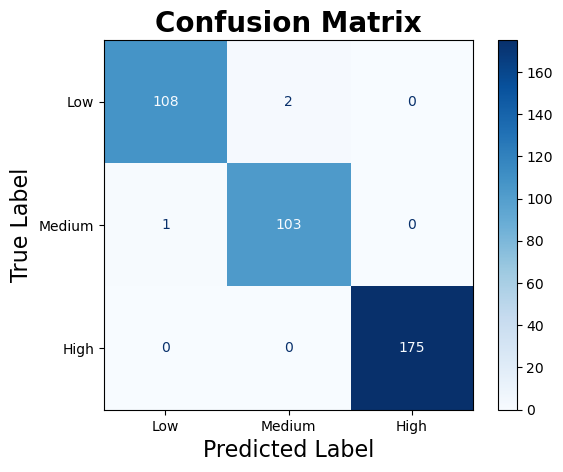

In [29]:
# Compute confusion matrix
cm:confusion_matrix = confusion_matrix(y_test, y_tuned_pred, labels=[0, 1, 2])
plt.figure(figsize=(12, 8))

# Display confusion matrix
disp:ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap=plt.cm.Blues)

# Display setting
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()

### ROC AUC Curve

In [1]:
# For Decision Trees, you typically use predict_proba for probabilities
y_pred_proba = cross_val_predict(best_rf_model, X_test, y_test, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

# Compute ROC curve and ROC AUC score
for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_test == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC AUC Curves', fontsize=20, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

NameError: name 'cross_val_predict' is not defined

### Forest visualisation

In [33]:
# Visualize the first tree in the forest
plt.figure(figsize=(180, 60))
plot_tree(best_rf_model.estimators_[0], feature_names=feature_names, filled=True, rounded=True, fontsize=36)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()